#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `...`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-обзор-данных" data-toc-modified-id="Загрузка-и-обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и обзор данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Рассмотрение-пропусков-в-данных" data-toc-modified-id="Рассмотрение-пропусков-в-данных-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Рассмотрение пропусков в данных</a></span></li><li><span><a href="#Дубликаты" data-toc-modified-id="Дубликаты-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Дубликаты</a></span></li><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Ресемплирование</a></span></li><li><span><a href="#Выводы-по-предобработке-данных" data-toc-modified-id="Выводы-по-предобработке-данных-1.1.6"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Выводы по предобработке данных</a></span></li></ul></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Разбивка-данных" data-toc-modified-id="Разбивка-данных-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Разбивка данных</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Сравнение-с-константной-моделью" data-toc-modified-id="Сравнение-с-константной-моделью-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Сравнение с константной моделью</a></span></li><li><span><a href="#Анализ-важности-признаков" data-toc-modified-id="Анализ-важности-признаков-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Анализ важности признаков</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Предобработка данных

In [1]:
!pip install phik -q
!pip install numpy==1.23.1 -q
!pip install numba -U -q
!pip install scikit-learn -U -q 
!pip install scipy -U -q 
!pip install shap -U -q

In [2]:
RANDOM_STATE = 2024

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))

import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.dummy import DummyRegressor, DummyClassifier

from sklearn.metrics import mean_squared_error

from scipy import stats as st

import shap

from phik.report import plot_correlation_matrix
from phik import report

import warnings

### Загрузка и обзор данных

#### Загрузка данных

In [3]:
df = ... # по просьбе Яндекс Практикума датасет открыто не распространяется

#### Обзор данных

In [4]:
display(df.head())

df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В данных имеется 26496 записей с количеством заказов такси с марта по август 2018

#### Рассмотрение пропусков в данных

In [5]:
print(df.isna().sum())

num_orders    0
dtype: int64


Пропуски в данных отсутствуют

#### Дубликаты
Проверим наличие дубликатов в индексе

In [6]:
print(df.index.duplicated().sum())

0


Дубликаты в индексе отсутствуют

#### Ресемплирование
Задача состоит в предсказании числа заказов на следующий час, поэтому проведем ресемплирование к часовому интервалу

In [7]:
df = df.resample('1H').sum()

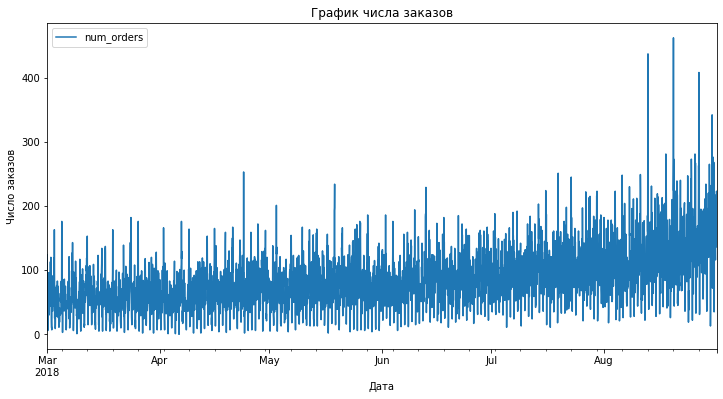

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(111)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
df.plot(ax=plt.gca(), ylabel='Число заказов', xlabel='Дата')
plt.title('График числа заказов')
plt.show()

#### Выводы по предобработке данных
В данных отсутсвуют дубликаты в индексах и пропуски и охватывают временной промежуток с марта по август 2018. Проведено ресемплирование к часовому интервалу. По графику временной ряд можно назвать почти стационарным

## Исследовательский анализ данных

### Тренды и сезонность

Residuals mean: -0.008130312689732936
Residuals mean: 24.696895960143493


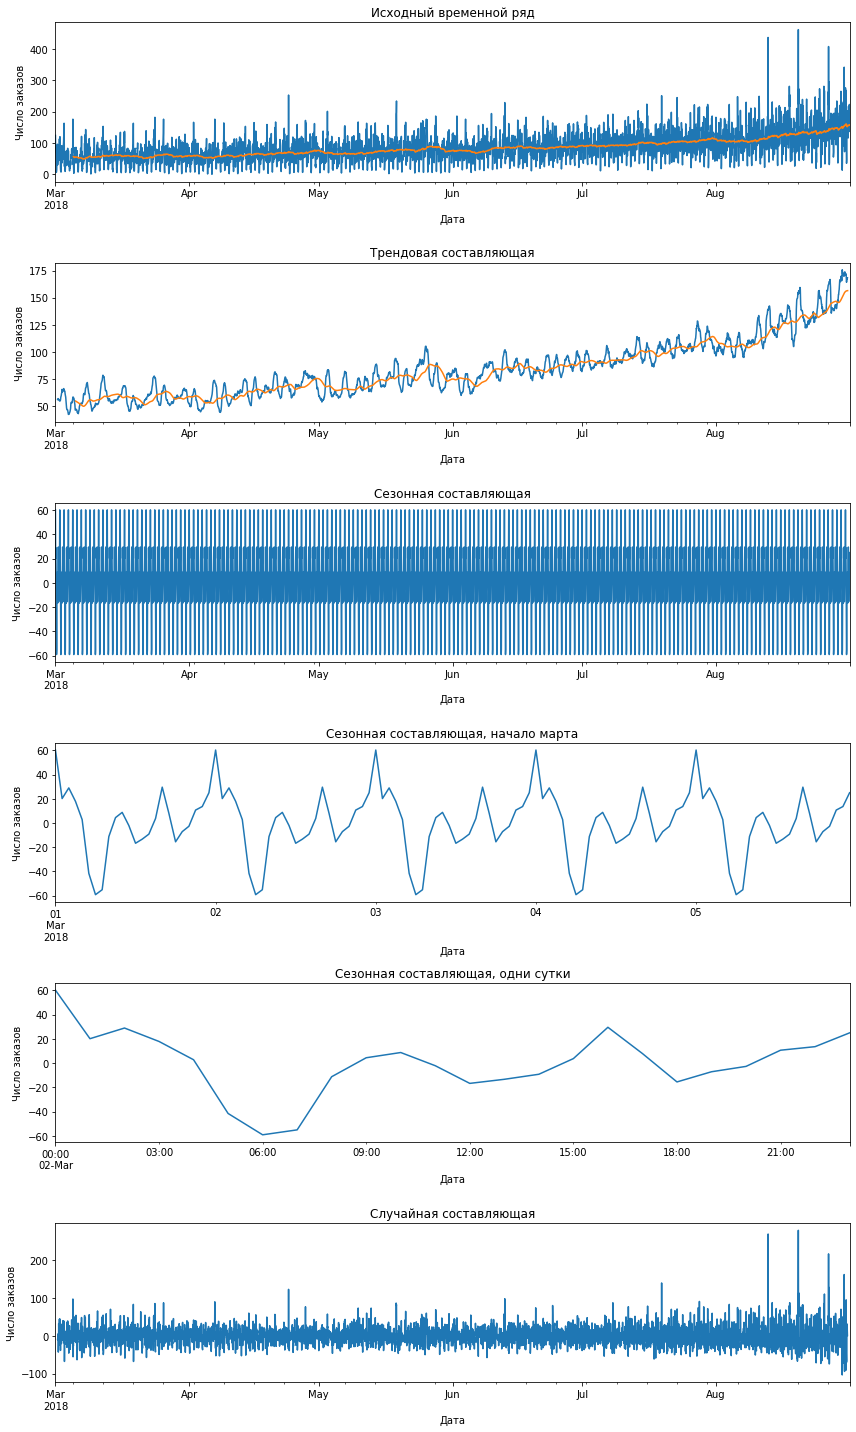

In [9]:
decomposed = seasonal_decompose(df['num_orders'])# < напишите код здесь >

plt.figure(figsize=(12, 20))
plt.subplot(611)
df['num_orders'].plot(ax=plt.gca(), ylabel='Число заказов', xlabel='Дата')
df['num_orders'].shift().rolling(100).mean().plot(ax=plt.gca(), ylabel='Число заказов', xlabel='Дата')
plt.title('Исходный временной ряд')
plt.subplot(612)
decomposed.trend.plot(ax=plt.gca(), ylabel='Число заказов', xlabel='Дата')
decomposed.trend.shift().rolling(100).mean().plot(ax=plt.gca(), ylabel='Число заказов', xlabel='Дата')
plt.title('Трендовая составляющая')
plt.subplot(613)
decomposed.seasonal.plot(ax=plt.gca(), ylabel='Число заказов', xlabel='Дата')
plt.title('Сезонная составляющая')
plt.subplot(614)
decomposed.seasonal['2018-03-01':'2018-03-05'].plot(ax=plt.gca(), ylabel='Число заказов', xlabel='Дата')
plt.title('Сезонная составляющая, начало марта')
plt.subplot(615)
decomposed.seasonal['2018-03-02':'2018-03-02'].plot(ax=plt.gca(), ylabel='Число заказов', xlabel='Дата')
plt.title('Сезонная составляющая, одни сутки')
plt.subplot(616)
decomposed.resid.plot(ax=plt.gca(), ylabel='Число заказов', xlabel='Дата')
plt.title('Случайная составляющая')
plt.tight_layout()

print('Residuals mean:', decomposed.resid.mean())
print('Residuals mean:', decomposed.resid.std())


По графикам видно что и тренд и усредненный ряд являются монотонно (и практически линейно) возрастающими. Поэтому нельзя назвать ряд стационарным

По графику сезонной составляющей видно что она имеет период в одни сутки и отражает изменение числа заказов в течение одного дня. Можно заметить, что пиковое число заказов приходится на полночь, после которого идет спад до суточного минимума в 6 утра. После этого идет рост числа заказов с локальными максимумами около 10 и 16 часов.

Можно предпположить, что максимумы суточного числа заказов связаны с характерным временем прибытия авиарейсов, а глобальный максимум около полуночи можно попытаться объяснить тем, что в это время такси является практически единственным способом выбраться из аэропорта. Получить информацию о изменении с более чем суточной периодичностью не представляется возможным

Случайные остатки имеют практически постоянную дисперсию (стандартное отклонение 25 с почти нулевым средним)

## Обучение

В данном разделе обучим модели 

### Создание признаков

Во временном ряде можно выделить две основные компоненты: трендовую и сезонную (шумы не учитываем) при этом будем считать их независимыми друг от друга. Поэтому добавим обе эти компоненты в качестве признаков.

Заметим, что компонента тренда после декомпозиции имеет осцилляции. Cгладим их бегущим средним, можно было бы попробовать снова провести декомпозицию чтобы получить сезонную компоненту большего периода (например недельного или месячного) но в даннной работе делать этого не будем. Размер окна выберем равным 100

In [10]:
df['trend'] = decomposed.trend.shift() # трендовая компонента тоже вроде делается окном поэтому добавляем сдвиг
df['seasonal'] = decomposed.seasonal

df['trend_ma_100'] = decomposed.trend.shift().rolling(100).mean()

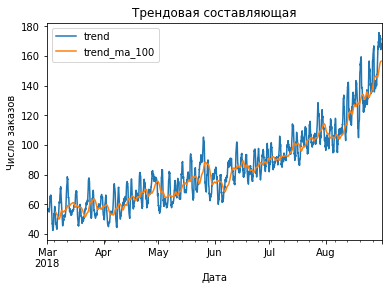

In [11]:
plt.subplot(111)
df[['trend','trend_ma_100']].plot(ax=plt.gca(), ylabel='Число заказов', xlabel='Дата')
plt.title('Трендовая составляющая')
plt.show()

Добавим в качестве признаков разность временного ряда и ее усреденении

In [12]:
df['diff'] = df['num_orders'].shift()-df['num_orders'].shift(2)
df['diff_ma_6'] = df['diff'].shift().rolling(6).mean()
df['diff_ma_24'] = df['diff'].shift().rolling(24).mean()

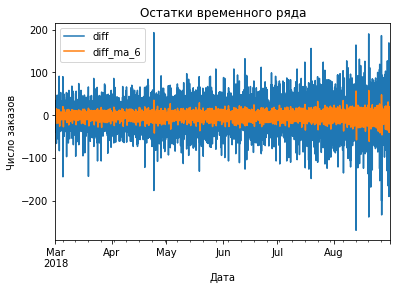

In [13]:
plt.subplot(111)
df[['diff','diff_ma_6']].plot(ax=plt.gca(), ylabel='Число заказов', xlabel='Дата')
plt.title('Остатки временного ряда')
plt.show()

Также выделим в качестве признаков номер месяца, день месяца и день недели

In [14]:
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

Также добавим признаки со сдвигом и усреднением

In [15]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['MA_'+str(rolling_mean_size)] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [16]:
df = make_features(df,4,100)

In [17]:
df.head(10)


,num_orders,trend,seasonal,trend_ma_100,diff,diff_ma_6,diff_ma_24,day,dayofweek,lag_1,lag_2,lag_3,lag_4,MA_100
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,60.248112,NaN,NaN,NaN,NaN,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,20.177074,NaN,NaN,NaN,NaN,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,28.982743,NaN,-39.0,NaN,NaN,1,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,17.885407,NaN,-14.0,NaN,NaN,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,NaN,2.791145,NaN,-5.0,NaN,NaN,1,3,66.0,71.0,85.0,124.0,NaN
2018-03-01 05:00:00,6,NaN,-41.563022,NaN,-23.0,NaN,NaN,1,3,43.0,66.0,71.0,85.0,NaN
2018-03-01 06:00:00,12,NaN,-59.182671,NaN,-37.0,NaN,NaN,1,3,6.0,43.0,66.0,71.0,NaN
2018-03-01 07:00:00,15,NaN,-55.104461,NaN,6.0,NaN,NaN,1,3,12.0,6.0,43.0,66.0,NaN
2018-03-01 08:00:00,34,NaN,-11.212840,NaN,3.0,-18.666667,NaN,1,3,15.0,12.0,6.0,43.0,NaN


### Разбивка данных
Выделим под тестовую выборку 10% данных

In [18]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop('num_orders',axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders',axis=1)
y_test = test['num_orders']

In [19]:
X_test.tail(50)

,trend,seasonal,trend_ma_100,diff,diff_ma_6,diff_ma_24,day,dayofweek,lag_1,lag_2,lag_3,lag_4,MA_100
datetime,,,,,,,,,,,,,
2018-08-29 22:00:00,166.520833,13.596814,147.652083,-21.0,-0.833333,4.041667,29,2,170.0,191.0,169.0,120.0,147.70
2018-08-29 23:00:00,169.166667,25.000503,147.988125,7.0,1.166667,-0.791667,29,2,177.0,170.0,191.0,169.0,148.24
2018-08-30 00:00:00,169.604167,60.248112,148.331250,88.0,-7.166667,0.708333,30,3,265.0,177.0,170.0,191.0,149.66
2018-08-30 01:00:00,169.250000,20.177074,148.661667,-49.0,17.666667,3.583333,30,3,216.0,265.0,177.0,170.0,150.77
2018-08-30 02:00:00,169.770833,28.982743,149.004167,1.0,16.000000,-0.750000,30,3,217.0,216.0,265.0,177.0,151.32
2018-08-30 03:00:00,167.979167,17.885407,149.336875,15.0,8.000000,2.708333,30,3,232.0,217.0,216.0,265.0,152.09
2018-08-30 04:00:00,165.645833,2.791145,149.645625,-39.0,6.833333,2.875000,30,3,193.0,232.0,217.0,216.0,152.28
2018-08-30 05:00:00,166.208333,-41.563022,149.953750,-7.0,3.833333,2.791667,30,3,186.0,193.0,232.0,217.0,151.33
2018-08-30 06:00:00,170.729167,-59.182671,150.293958,-130.0,1.500000,2.083333,30,3,56.0,186.0,193.0,232.0,150.33


### Обучение

In [20]:
num_columns = X_train.select_dtypes(include='number').columns

################################################
encoder_pipe = Pipeline(
    [
        ('fillna1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encode', OneHotEncoder(drop='first', handle_unknown='ignore')),
        ('fillna2', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )
################################################
ranged_encoder_pipe = Pipeline(
    [
        ('fillna1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encode', OneHotEncoder(drop='first', handle_unknown='ignore')),
        ('fillna2', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )
################################################
scaler_pipe = Pipeline(
    [
        ('scale', MinMaxScaler())
    ]
    )
################################################
data_preprocessor = ColumnTransformer(
    [
        #('encoder', encoder_pipe, cat_columns),
        #('ranged_encoder', ranged_encoder_pipe, ranged_columns),
        ('scaler', scaler_pipe, num_columns)
    ], 
    remainder='passthrough'
)
################################################
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [21]:
################################################
parameters = [
    #KNeighborsRegressor() 
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(1, 20),
        'models__weights':["uniform", "distance"],
        'preprocessor__scaler__scale': [StandardScaler(), MinMaxScaler()],
        #'preprocessor__encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)],
        #'preprocessor__ranged_encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, categories=categories)]
    },
    #DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__criterion':['squared_error', 'friedman_mse', 'absolute_error','poisson'],
        #'models__max_depth': range(2, 30),
        'models__max_depth': [None] + [i for i in range(2, 20)],
        'models__min_samples_split':range(2,100),
        'models__min_samples_leaf':range(1,40),
        'preprocessor__scaler__scale': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        #'preprocessor__encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)],
        #'preprocessor__ranged_encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, categories=categories)]
    },
    #LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__scaler__scale': [StandardScaler(), MinMaxScaler()],
        #'preprocessor__encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)],
        #'preprocessor__ranged_encoder__encode':[OneHotEncoder(handle_unknown='ignore'),OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan, categories=categories)]
    }
] 

In [22]:
tscv = TimeSeriesSplit(n_splits=5)

grid_search = RandomizedSearchCV(
    pipe_final, 
    parameters, 
    cv = tscv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=100,
    scoring='neg_root_mean_squared_error'
)

In [23]:
grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('scaler',
                                                                               Pipeline(steps=[('scale',
                                                                                                MinMaxScaler())]),
                                                                               Index(['trend', 'seasonal', 'trend_ma_100', 'diff', 'diff_ma_6', 'diff_ma_24',
       'day', 'dayofweek', 'lag_1', 'lag_2', '...
                                                               6, 7, 8, 9, 10,
                                                               11, 12, 13, 14,
                                                               15, 16, 17, 18,
                                                               19],
                                         'models__min_samples_leaf': range(1, 40),
                                         'models__min_samples_split': range(2, 100),
                                         'preprocessor__scaler__scale': [StandardScaler(),
                                                                         MinMaxScaler(),
                                                                         'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__scaler__scale': [StandardScaler(),
                                                                         MinMaxScaler()]}],
                   random_state=2024, scoring='neg_root_mean_squared_error')

In [24]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_params_)

print ('Метрика лучшей модели при кросс-валидации (для временных рядов):', abs(grid_search.best_score_))

Лучшая модель и её параметры:

 {'preprocessor__scaler__scale': MinMaxScaler(), 'models__min_samples_split': 7, 'models__min_samples_leaf': 27, 'models__max_depth': 6, 'models__criterion': 'squared_error', 'models': DecisionTreeRegressor(random_state=2024)}
Метрика лучшей модели при кросс-валидации (для временных рядов): 24.811610653665724


При кросс-валидации была выбрана лучшая модель, ей оказалась модель DecisionTreeRegressor с вышеописанными гиперпараметрами

Значение метрики при кросс-валидации равно 24.81

## Тестирование

In [25]:
print("RMSE тестовой выборки:", mean_squared_error(grid_search.predict(X_test),y_test)**0.5)

RMSE тестовой выборки: 47.892024702382535


### Сравнение с константной моделью

Сравним лучшую модель с моделью возвращающей среднее значение на обучающей выборке

In [26]:
train_mean = y_train.mean()

print("RMSE константной модели на тестовой выборки:", mean_squared_error([train_mean]*y_test.shape[0],y_test)**0.5)

RMSE константной модели на тестовой выборки: 84.25340144639995


Как видно метрика лучшей модели заметно превосходит метрику константной модели

### Анализ важности признаков

In [27]:
tr = grid_search.best_estimator_[0]
model = grid_search.best_estimator_[1]

X_test_tr = tr.transform(X_test)

explainer = shap.Explainer(model.predict, X_test_tr, feature_names=tr.get_feature_names_out())
shap_values = explainer(X_test_tr)

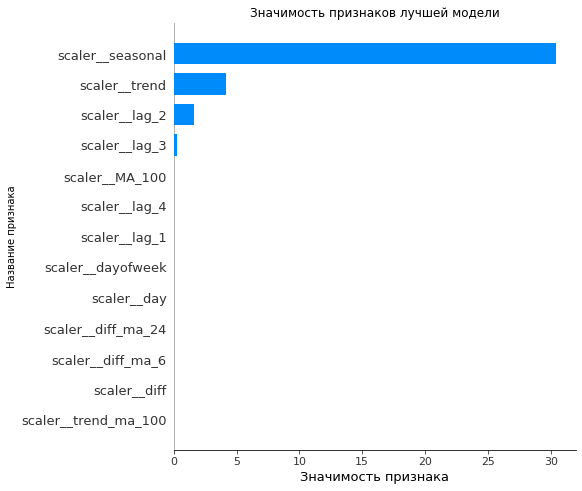

In [28]:
ax = shap.summary_plot(shap_values, plot_type="bar",show=False)
plt.title('Значимость признаков лучшей модели')
plt.xlabel('Значимость признака')
plt.ylabel('Название признака')
plt.show()

Значение метрики на тестовой выборке равняется 47.89

Это заметно больше чем на тренировочной и потому можно сказать, что модель несколько переобучена, тем не менее значение метрики неплохое

В ходе проведенного анализа важности признаков было выяснено что наиболее значимыми являются сезонная и трендовая компоненты (`seasonal` и `trend`) и отстающие значения (`lag_2`, `lag_3`)

## Выводы

В данной работе исследовались исторические данные компании «Чётенькое такси» о заказах такси в аэропортах. Целью работы было создание модели для предсказания количества заказов такси на следующий час с целью привлечения большего числа водителей в период пиковой нагрузки

Результатом работы должна была стать модель со значением метрики RMSE на тестовой выборке не больше 48.

В ходе работы были рассмотрены предоставленные данные и обучено несколько моделей, среди которых была отбрана лучшая.

Ей оказалась модель DecisionTreeRegressor для который наиболее важными являются признаки `diff` и `lag_1`

Значение метрики при кросс-валидации равно 24.81

Значение метрики на тестовой выборке равно 47.89